In [23]:
'''
Figure 1. Representing methods for this process. 

Things to do:
    Verify lined up
    Verify correct offsets, be robust
'''

'\nFigure 1. Representing methods for this process. \n\nThings to do:\n    Verify lined up\n    Verify correct offsets, be robust\n'

In [24]:
from preprocessing import get_bold_task, task_events
from pupillometry import pupillometry
from persistence import get_dgms, plot_dgms

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec, patches
from matplotlib.ticker import AutoMinorLocator
from matplotlib import collections as mc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Helvetica"

from time import time

from gudhi.wasserstein import wasserstein_distance as qwas

from umap import UMAP
from sklearn.manifold import Isomap, TSNE

from scipy.interpolate import CubicSpline

os.chdir('/Users/spencerbrown/PycharmProjects/Neuro')

cmap = [
    '#003f5c',
    '#2f4b7c',
    '#665191',
    '#a05195',
    '#d45087',
    '#f95d6a',
    '#ff7c43',
    '#ffa600']

In [25]:
atlas = 'Schaefer2018_fslr32k'
task = 'MOTOR'
# parcels = [200, 300, 400]
parcels = 300
dims = 2 # Number of homology dimensions to compute.
frames = 284
TR = 0.72
acquisition = frames * TR

bw = 15 # std of gaussian kernel.

subject = 100610

In [26]:
#t = np.linspace(0, acquisition, frames)
def kern_a(std, offset):
    t = np.arange(frames)
    sig2 = 2 * std * std
    w = np.exp(-1 * ((t - offset) ** 2) / sig2)
    w[int(offset+0.5):] = 0
    scale = 2 / (std*np.sqrt(2*np.pi))
    w = w * scale
    return w

def kern_b(std, offset):
    t = np.arange(frames)
    sig2 = 2 * std * std
    w = np.exp(-1 * ((t - offset) ** 2) / sig2)
    w[:int(offset+0.5)] = 0
    scale = 2 / (std*np.sqrt(2*np.pi))
    w = w * scale
    return w

# plt.figure(figsize=(6, 2))
# plt.plot(t, kern_a(std=20, offset=100.5), alpha=0.5, c=cmap[0])
# plt.plot(t, kern_b(std=20, offset=100.5), alpha=0.5, c=cmap[3])
# plt.axvline(100.5, c='k', linestyle='--')

In [27]:
t0 = time()
sub = subject # subject to consider
run = 0

bold = get_bold_task(sub, run, atlas, parcels, task)

t_frames = np.arange(2*bw+0.5, frames - 2*bw-0.5)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [28]:
adjs_a = []
adjs_b = []
L2 = []
for w in t_frames:
    ka = kern_a(bw, w)
    kb = kern_b(bw, w)

    bold_a = bold * ka
    adj_a = 1 - np.corrcoef(bold_a)

    bold_b = bold * kb
    adj_b = 1 - np.corrcoef(bold_b)
    
    adjs_a.append(adj_a)
    adjs_b.append(adj_b)
    L2.append(np.linalg.norm((adj_b - adj_a), ord='fro'))


adjs_a = np.stack(adjs_a, axis=0)
adjs_b = np.stack(adjs_b, axis=0)
L2 = np.array(L2)

print(f'Completed subject {sub} run {run}, Time elapsed: {time()-t0}')

Completed subject 100610 run 0, Time elapsed: 1.8216018676757812


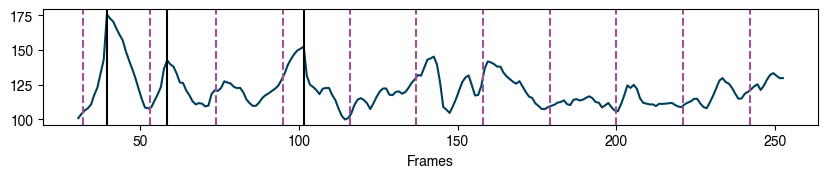

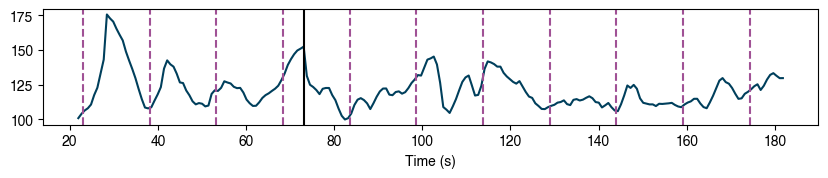

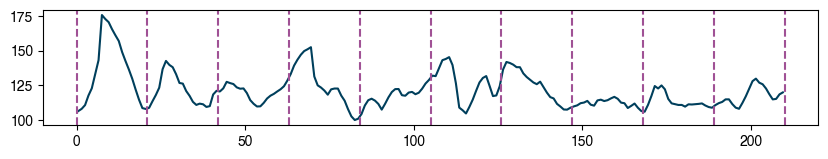

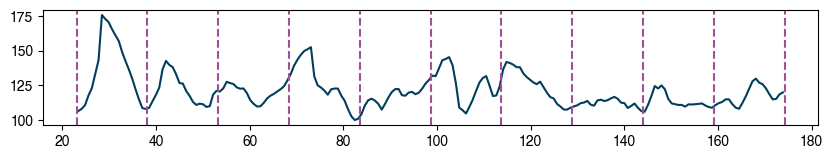

In [40]:
cues = np.arange(11, 284, 21) # In frame space.
    # Intelligently set up so each event is 21 frames long. 
cues_frame = cues[1:-1] # dropping first and last.
cues_time = cues_frame * TR # converted to a time space. 
cues_offset = cues_frame - cues_frame[0]

t_time = t_frames * TR

start_drop = np.ceil(cues_frame[0] - t_frames[0]).astype(int)
acquisition_valid = (len(cues_frame) - 1) * 21

t_offset = np.arange(acquisition_valid) + 0.5
L2_new = L2[start_drop:start_drop + acquisition_valid]


''' Plotting in a frame domain '''
plt.figure(figsize=(10, 1.5))
plt.plot(t_frames, L2, c=cmap[0])
plt.xlabel('Frames')

plt.axvline(t_frames[9], c='k')
plt.axvline(t_frames[28], c='k')
plt.axvline(t_frames[71], c='k')

for i in cues_frame:
    plt.axvline(i, c=cmap[3], linestyle='--')
plt.show()


''' Plotting in a time domain '''
plt.figure(figsize=(10, 1.5))
plt.plot(t_time, L2, c=cmap[0])
plt.xlabel('Time (s)')
for i in cues_time:
    plt.axvline(i, c=cmap[3], linestyle='--')

plt.axvline((71+t_frames[0])*TR, c='k')
plt.show()

''' Frame offset by cue_0 domain '''
plt.figure(figsize=(10, 1.5))
plt.plot(t_offset, L2_new, c=cmap[0])
for i in cues_offset:
    plt.axvline(i, c=cmap[3], linestyle='--')
plt.show()

plt.figure(figsize=(10, 1.5))
plt.plot(t_offset*TR + cues_time[0], L2_new, c=cmap[0])
for i in cues_time:
    plt.axvline(i, c=cmap[3], linestyle='--')
plt.show()

# Note - reconsitute event type?

In [30]:
print(cues)
print(cues * TR)
print(cues_time)

[ 11  32  53  74  95 116 137 158 179 200 221 242 263]
[  7.92  23.04  38.16  53.28  68.4   83.52  98.64 113.76 128.88 144.
 159.12 174.24 189.36]
[ 23.04  38.16  53.28  68.4   83.52  98.64 113.76 128.88 144.   159.12
 174.24]


In [35]:
'''
Run cues:
8.05
23.163
38.291
53.431
68.545
98.666
113.793
128.92
159.041
174.168
'''

'''
Note - can go from: last cue until cue + 21s
    Given - that is a state on it's own. 
Cues - accounts for final + 21 for all runs.
However - recall that the role for dropping the fir stand last is more related to needed to account for the gassian. 

Note - njust need a comment saying what the critiera is for things to be valid.

'''

testy = np.array([8.05, 23.163, 38.291, 53.431, 68.545, 98.666, 113.793, 128.92, 159.041, 174.168])
print(testy / TR)
print(cues*TR)

[ 11.18055556  32.17083333  53.18194444  74.20972222  95.20138889
 137.03611111 158.04583333 179.05555556 220.89027778 241.9       ]
[  7.92  23.04  38.16  53.28  68.4   83.52  98.64 113.76 128.88 144.
 159.12 174.24 189.36]


In [36]:
cues

array([ 11,  32,  53,  74,  95, 116, 137, 158, 179, 200, 221, 242, 263])